# Project3

In [1]:
from collections import defaultdict

from pyspark.sql.session import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    lead, lag, unix_timestamp, 
    when, col, sum, udf, avg
)
from pyspark.sql.types import StringType
import pyspark

from delta import *
from delta.tables import *

import json
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, Word2Vec
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col, lower, regexp_replace
import re
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import lit
import numpy as np



builder = (
    SparkSession.builder.appName("Refr")
    .config("spark.sql.extensions", 
            "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", 
            "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

## Data discovery and processing

In [2]:
# Schema
data = spark.read.format("json").option("inferSchema","true").load("dblp-ref-0.json")
schema = data.schema

for i in range(1, 4):
    file_name = f"dblp-ref-{i}.json"
    df = spark.read.json(file_name, schema=schema)
    data = data.union(df)

data.printSchema()
data.show(5)
data.describe().show()



root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|
|This paper descri...

### Remove non-English titles

In [3]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

data = data.na.drop(subset=["title"])

# Ascii
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

# UDF
is_ascii_udf = udf(is_ascii, BooleanType())


# Filter
df_eng = data.filter(is_ascii_udf(data['title']))

#df_eng.show(5)



### Remove stop words and lower case

In [4]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Lower
df_eng = df_eng.withColumn("title", lower(col("title")))

tokenizer = Tokenizer(inputCol="title", outputCol="words")
df_eng = tokenizer.transform(df_eng)

# Word list
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']

# Stop words
stop_words = StopWordsRemover().getStopWords()

stop_words = stop_words + custom_stop_words

# StopWordRemover
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=stop_words)

df_eng = remover.transform(df_eng)


In [5]:
#print(stop_words)

### Regex

In [6]:
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql.functions import lower, col
from pyspark.sql.functions import concat_ws

# toString
df_eng = df_eng.withColumn("filtered", concat_ws(" ", col("filtered")))

# Regex
pattern = "[!()-\[\]{};:'\"\,<>./?@#$%^&*_~]"

# Regex transform
tokenizer = RegexTokenizer(inputCol="filtered", outputCol="low_filtered", pattern=pattern, gaps=True)
df_eng = tokenizer.transform(df_eng)




In [7]:
#df_eng.select("low_filtered").show(25)

### Word2Vec

In [8]:
from pyspark.ml.feature import Word2Vec

df_eng = df_eng.repartition(10)

word2Vec = Word2Vec(vectorSize=5, minCount=2, inputCol="low_filtered", outputCol="features")

# Fit the model
model = word2Vec.fit(df_eng)

# Transform the DataFrame
result = model.transform(df_eng)


In [9]:
# Find synonyms
#synonyms = model.findSynonyms('psychology', 5)
#for word, cosine_distance in synonyms.collect():
#    print("{}: {}".format(word, cosine_distance))

In [10]:
result = result.drop('abstract','venue','year','authors','n_citation','references','words','filtered')

In [11]:
#result.show()

#### Elbow method

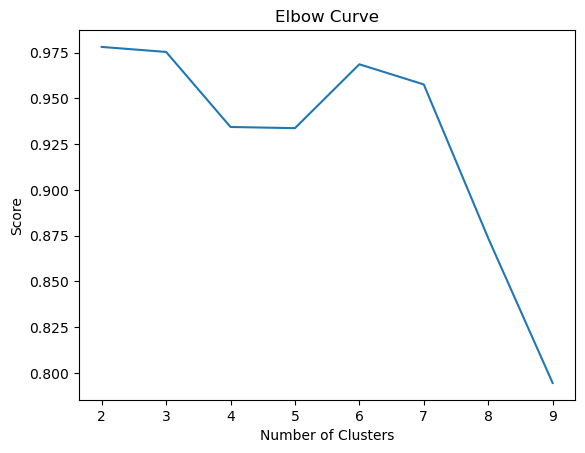

In [15]:
# Calculate cost and plot
import numpy as np
import pandas as pd

n=10
cost = np.zeros(n)

for k in range(2,n):
    kmeans = KMeans(k=k, seed=3)
    model = kmeans.fit(result)
    #cost[k] = model.computeCost(transformed_data)
    clusterdData = model.transform(result)
    evaluator = ClusteringEvaluator()
    cost[k] = evaluator.evaluate(clusterdData)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,n)
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

K = 5

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA

# Apply PCA
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)
result = model.transform(result)

# Apply KMeans
kmeans = KMeans(k=5, seed=1, featuresCol="pcaFeatures")  
model = kmeans.fit(result.select('pcaFeatures'))
predictions = model.transform(result)


In [13]:
#predictions.show()

## Search engine

In [14]:
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import FloatType
import numpy as np

# Define the Euclidean distance function
def euclidean_distance(vec1, vec2):
    return float(np.linalg.norm(np.array(vec1) - np.array(vec2)))

# Register the UDF
udf_euclidean_distance = udf(euclidean_distance, FloatType())

def find_related_titles(given_id):
    # Get the row with the given ID
    given_row = predictions.filter(predictions.id == given_id).collect()[0]
    given_features = given_row['pcaFeatures']
    
    # Convert the features to a list
    given_features_list = given_features.tolist()
    
    # Get the cluster of the given ID
    given_cluster = given_row['prediction']
    
    # Filter the rows in the same cluster
    cluster_rows = predictions.filter(predictions.prediction == given_cluster)
    
    # Compute the Euclidean distance to the given ID for each row
    distances = cluster_rows.withColumn('distance', udf_euclidean_distance(col('pcaFeatures'), lit(given_features_list)))
    
    # Sort by distance and limit to top 5
    sorted_rows = distances.sort('distance').limit(5)
    
    # Get the related titles
    related_titles = sorted_rows.select('title').rdd.flatMap(lambda x: x).collect()
    
    return related_titles


a query language solution for shortest path problems in cyclic geometrics.
aligning supply chain strategy with product life cycle stages
the research on the value experience in the brand culture of sushan and the design of product system service
study on corba-based load balance algorithm
a comprehensive model of usability


### Search by Id

given_id = "22dd3580-06bb-4e96-9f28-4bb3c3bc5eab"
related_titles = find_related_titles(given_id)

# Print the related titles
for title in related_titles:
    print(title)

## Possible next steps to improve the project :

Enrich the data to include metadata about the articles to increase accuracy / 
Gather feedback for the same purpose /
Include TF-IDF 